<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [3]:
from sklearn.metrics import roc_auc_score

# Первая часть. Исследование

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv('./train.csv')

In [6]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

- Мы видим, что признак 'TotalSpent' иммет тип object , хотя является float. Нужно поменять. Однако это происходит потому, что тем есть пропущенные значения в виде пробела, т.е. " ".


In [8]:
data.loc[data['TotalSpent'] == ' ', 'TotalSpent'] = np.nan
data['TotalSpent'] = data['TotalSpent'].astype(float) # Поменяем тип
data.loc[data['TotalSpent'].isnull(), 'TotalSpent'] = data['TotalSpent'].median()
data['IsSeniorCitizen'] = data['IsSeniorCitizen'].astype(object) # Сделаем категориальную переменную, категориальной.

In [9]:
data.describe()

,ClientPeriod,MonthlySpending,TotalSpent,Churn
count,5282.000000,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,2289.889086,0.262022
std,24.550326,30.176464,2267.371263,0.439776
min,0.000000,18.250000,18.800000,0.000000
25%,9.000000,35.462500,401.587500,0.000000
50%,29.000000,70.400000,1410.250000,0.000000
75%,55.000000,90.050000,3795.212500,1.000000
max,72.000000,118.750000,8684.800000,1.000000


- Данные без Выбросов

In [10]:
data.head(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


<AxesSubplot:>

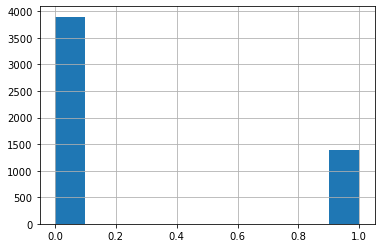

In [11]:
data['Churn'].hist()

In [12]:
data['Churn'].value_counts(normalize=True)

0    0.737978
1    0.262022
Name: Churn, dtype: float64

- Целевая переменная имеет дисбаланс, но не очень сильный.

#### По описательной статистике, мы видели, что на первый взгляд непрерывные признаки не имеют выбросов, для наглядности можем построить боксплоты и убедиться.

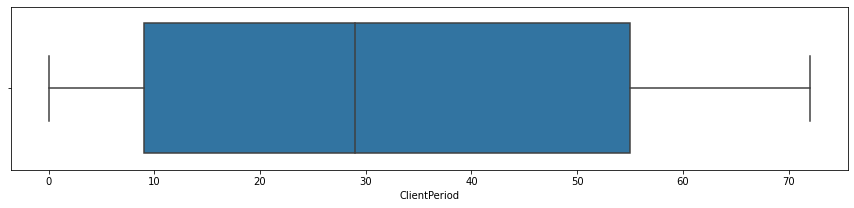

In [13]:
plt.figure(figsize=(15,3))
sns.boxplot(data['ClientPeriod']);

- Как мы видим выбросов нет. Посмотрим  на распределение целевой переменной в разрезе 'ClientPeriod'.

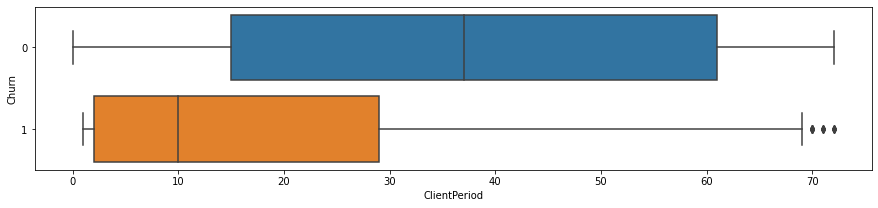

In [14]:
plt.figure(figsize=(15,3))
sns.boxplot(x='ClientPeriod', y='Churn', data=data[['ClientPeriod', 'Churn']], orient='h');

- Как мы видим распределение явно отличается, среднее 1 класса по этому признаку смещено ближе к 0. 

''

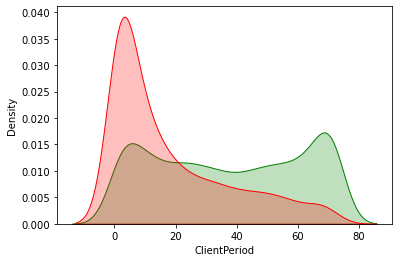

In [15]:
churn_spread = data[['ClientPeriod', 'Churn']]
churn_1 = churn_spread.loc[churn_spread['Churn'] == 1, 'ClientPeriod']
churn_0 = churn_spread.loc[churn_spread['Churn'] == 0, 'ClientPeriod']
sns.kdeplot(churn_0, shade=True,  color='g')
sns.kdeplot(churn_1, shade=True,  color='r')
;

- Исходя из наблюдений, можно сделать вывод, что люди на много чаще уходят при ClientPeriod (т.к. нет описания призноков, будем считать, что это время, которое человек провел пользуясь услугами.) близким к 0. Можно интерпритировать это, как то, что человек принимает решение,  о том, нравится ему компания или нет в первые дни. Как рекомендация, в период 0 - 20 предоставлять доп скидки.

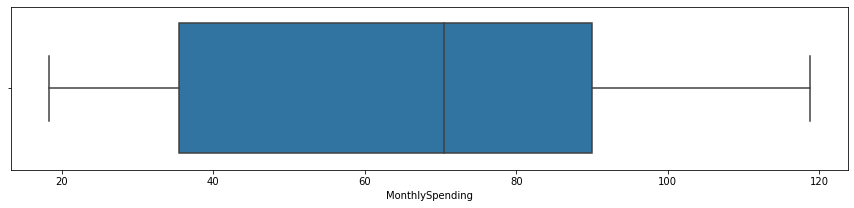

In [16]:
plt.figure(figsize=(15,3))
sns.boxplot(data['MonthlySpending']);

- Как мы видим выбросов нет. Посмотрим  на распределение целевой переменной в разрезе 'ClientPeriod'.

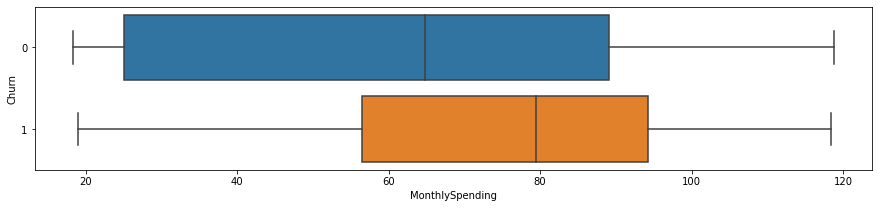

In [17]:
plt.figure(figsize=(15,3))
sns.boxplot(x='MonthlySpending', y='Churn', data=data[['MonthlySpending', 'Churn']], orient='h');

- В целом распределение похоже, хотя средние также смещены. Посмотрим на плотность.

<AxesSubplot:xlabel='MonthlySpending', ylabel='Density'>

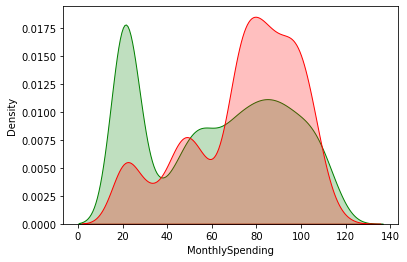

In [18]:
churn_spread = data[['MonthlySpending', 'Churn']]
churn_1 = churn_spread.loc[churn_spread['Churn'] == 1, 'MonthlySpending']
churn_0 = churn_spread.loc[churn_spread['Churn'] == 0, 'MonthlySpending']
sns.kdeplot(churn_0, shade=True,  color='g')
sns.kdeplot(churn_1, shade=True,  color='r')

- Видна прямая зависимость количества ушедших от ежемесячного расхода.

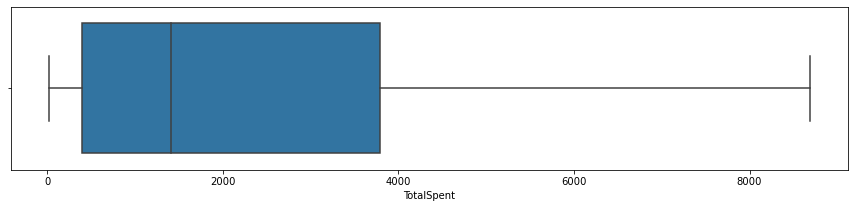

In [19]:
plt.figure(figsize=(15,3))
sns.boxplot(data['TotalSpent']);

- Выбросов нет.

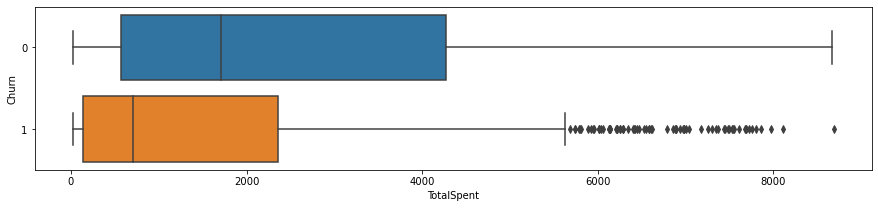

In [20]:
plt.figure(figsize=(15,3))
sns.boxplot(x='TotalSpent', y='Churn', data=data[['TotalSpent', 'Churn']], orient='h');

<AxesSubplot:xlabel='TotalSpent', ylabel='Density'>

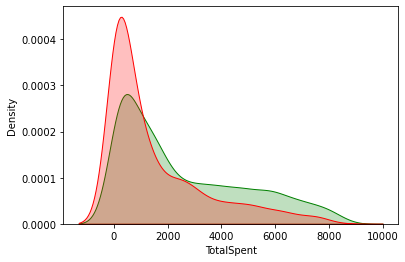

In [21]:
churn_spread = data[['TotalSpent', 'Churn']]
churn_1 = churn_spread.loc[churn_spread['Churn'] == 1, 'TotalSpent']
churn_0 = churn_spread.loc[churn_spread['Churn'] == 0, 'TotalSpent']
sns.kdeplot(churn_0, shade=True,  color='g')
sns.kdeplot(churn_1, shade=True,  color='r')

- Хоть средняя смещена, но не вижу выдающейся разницы, как на предыдущих признаках.  

In [22]:
cols_for_pair = ['ClientPeriod','MonthlySpending', 'TotalSpent', 'Churn']

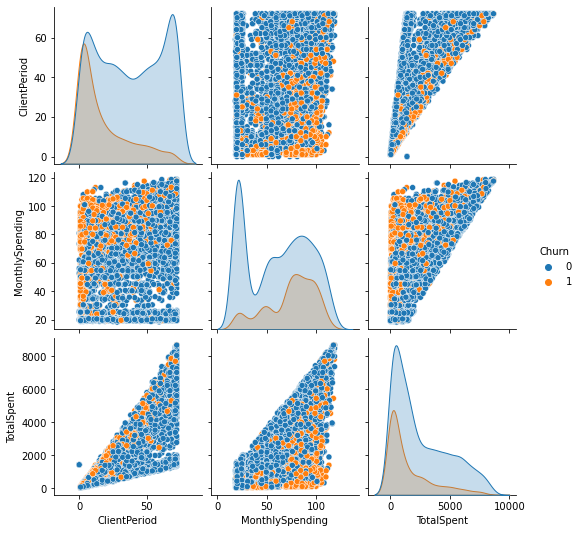

In [23]:
sns.pairplot(data=data[cols_for_pair], hue='Churn')

- Стоит обратить внимание, на большое скопление ушедших на пересечении больших месячных расходов и малого "клиентского периода".

<AxesSubplot:>

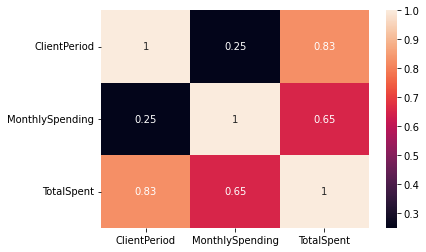

In [24]:
sns.heatmap(data[num_cols].corr(), annot=True)

#### Посмотри категориальные признаки

In [25]:
for cat in cat_cols:
    print(data[cat].value_counts())

Male      2655
Female    2627
Name: Sex, dtype: int64
0    4440
1     842
Name: IsSeniorCitizen, dtype: int64
No     2705
Yes    2577
Name: HasPartner, dtype: int64
No     3676
Yes    1606
Name: HasChild, dtype: int64
Yes    4761
No      521
Name: HasPhoneService, dtype: int64
No                  2511
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64
Fiber optic    2341
DSL            1800
No             1141
Name: HasInternetService, dtype: int64
No                     2612
Yes                    1529
No internet service    1141
Name: HasOnlineSecurityService, dtype: int64
No                     2332
Yes                    1809
No internet service    1141
Name: HasOnlineBackup, dtype: int64
No                     2317
Yes                    1824
No internet service    1141
Name: HasDeviceProtection, dtype: int64
No                     2604
Yes                    1537
No internet service    1141
Name: HasTechSupportAccess, dtype: int64
No    

- Напишем функцию, чтобы можно было посмотреть распределение целевой переменной в каждой категории

In [26]:
def countplot_iter(list_cat_cols, target, data):
    for i in list_cat_cols:
        yield sns.countplot(x=i, hue=target, data=data);

In [27]:
iter = countplot_iter(cat_cols, "Churn", data)

<AxesSubplot:xlabel='Sex', ylabel='count'>

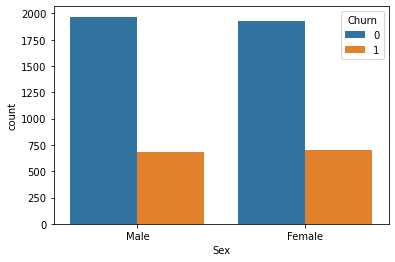

In [28]:
next(iter)

Пролистав все признаки, самыми интересными стали 'HasInternetService', 'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription', 'HasContractPhone', 'PaymentMethod'

- Посмотрим те, которые меня заинтересовали больше всего.

<AxesSubplot:xlabel='PaymentMethod', ylabel='count'>

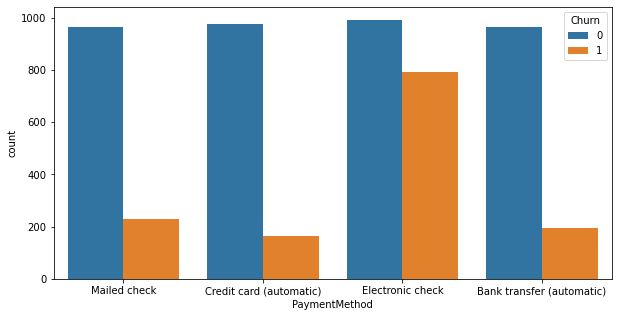

In [29]:
plt.figure(figsize=(10,5))
sns.countplot(x='PaymentMethod', hue="Churn", data=data)

Посмотрите, как сильно выделяется распределение в подкатегории Electronic check. Можно сделать вывод, что у людей какие-то проблемы с оплатой через этот метод (возможно какйто налог или еще что). Вероятно даже имеет смысл сделать из этого признака бинарный  по подкатегории "Elecronic check" да\нет.

- Также Есть группа категориальных переменных начинающихся с Has% это означает подключенная услуга. Эти группы разделены логически на 2 подгруппы, Интернет сервисы и телефония. 

<AxesSubplot:xlabel='HasInternetService', ylabel='count'>

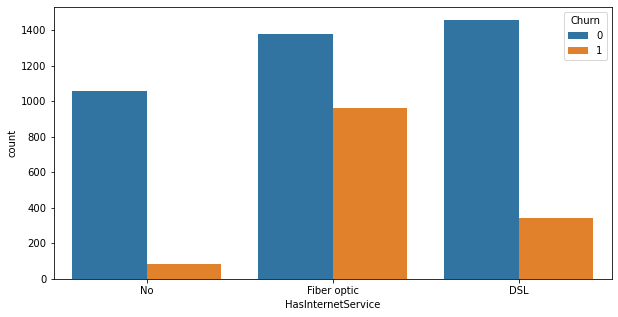

In [30]:
plt.figure(figsize=(10,5))
sns.countplot(x='HasInternetService', hue="Churn", data=data)

<AxesSubplot:xlabel='HasOnlineBackup', ylabel='count'>

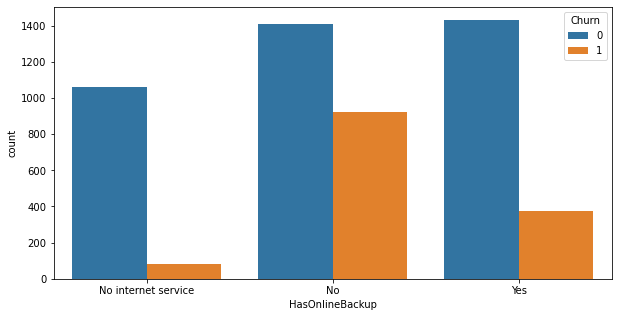

In [31]:
plt.figure(figsize=(10,5))
sns.countplot(x='HasOnlineBackup', hue="Churn", data=data)

<AxesSubplot:xlabel='HasDeviceProtection', ylabel='count'>

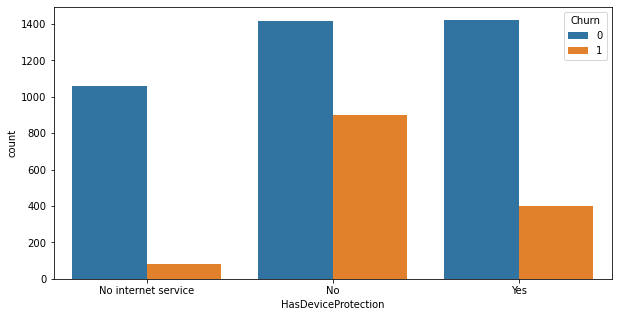

In [32]:
plt.figure(figsize=(10,5))
sns.countplot(x='HasDeviceProtection', hue="Churn", data=data)

- Как мы видим, люди которые пользуются только телефонией, почти не отказываются от услуг.

Также еще один интересный признак 'HasTechSupportAccess', как видно из название это доступ к техподдержке.

<AxesSubplot:xlabel='HasTechSupportAccess', ylabel='count'>

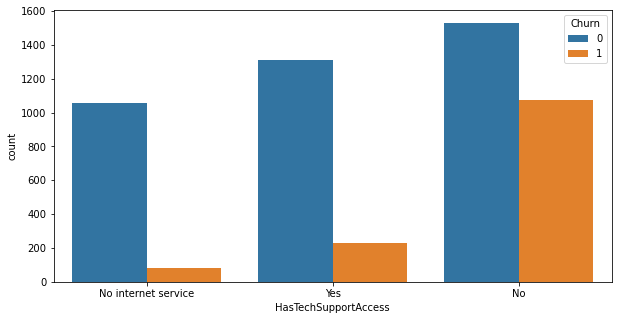

In [33]:
plt.figure(figsize=(10,5))
sns.countplot(x='HasTechSupportAccess', hue="Churn", data=data)

Посмотрите, какая большая разница между теми, кто не имел доступ и теми кто имел. Для маркетологов стоит задуматься, может имеет смысл сделать поддержку более "доступной".

<AxesSubplot:xlabel='HasContractPhone', ylabel='count'>

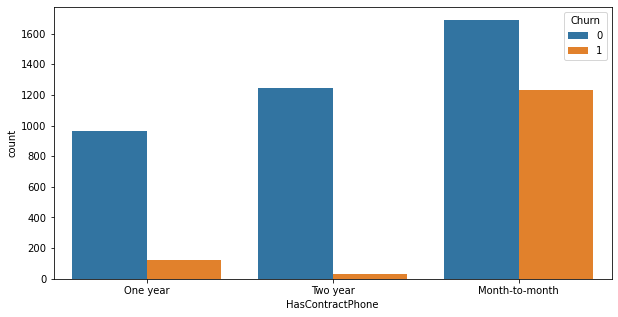

In [34]:
plt.figure(figsize=(10,5))
sns.countplot(x='HasContractPhone', hue="Churn", data=data)

Можно интерпритировать, это как человек который платит на год или два вперед, уверен, что он не уйдет.=)

## Строим модели

In [35]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve

#### Сперва подготовим данные.

- Создаем дамми переменные

In [36]:
X = pd.get_dummies(data[feature_cols], drop_first=True)
y = data[target_col]

- Разделяем на трейн \ валид выборки

In [37]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=47)

- Стандартизируем

In [38]:
stand = StandardScaler()

In [39]:
X_train[num_cols] = stand.fit_transform(X_train[num_cols])
X_valid[num_cols] = stand.transform(X_valid[num_cols])

## Теперь можно опробовать линейные модельки

#### № 1 LogisticRegressionCV стандарт

- Попробуем стандартную лог регрессию. По умолчанию тут используется L2 регуляризация.

In [40]:
lrcv = LogisticRegressionCV(cv = 5, scoring='roc_auc')
lrcv.fit(X_train, y_train)

LogisticRegressionCV(cv=5, scoring='roc_auc')

In [41]:
y_train_predicted = lrcv.predict_proba(X_train)[:, 1]
y_valid_predicted = lrcv.predict_proba(X_valid)[:, 1]

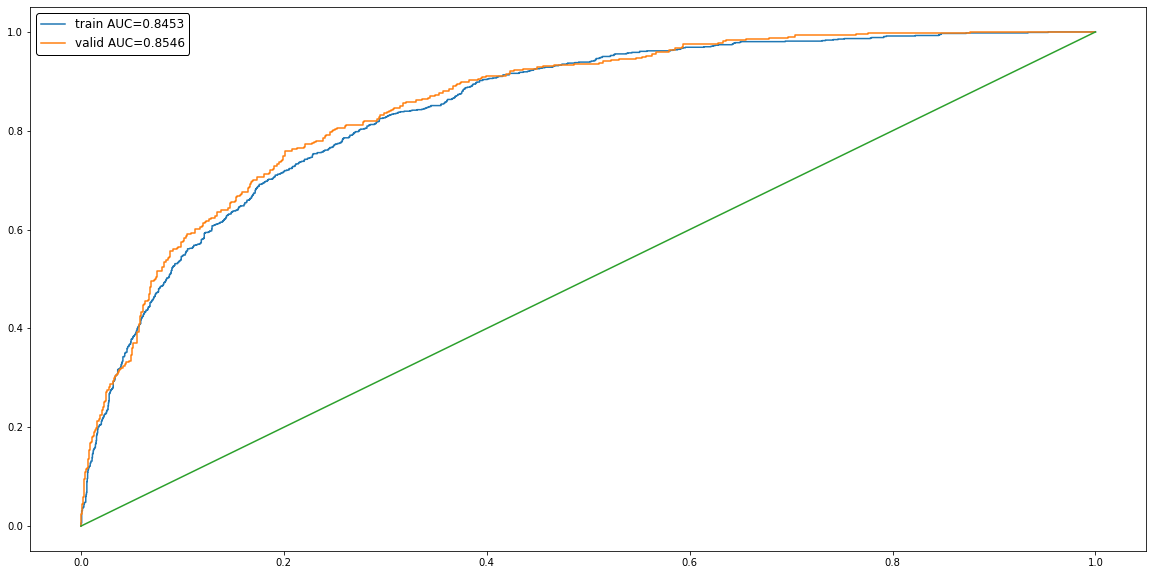

In [42]:
train_auc = roc_auc_score(y_train, y_train_predicted)
valid_auc = roc_auc_score(y_valid, y_valid_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_valid, y_valid_predicted)[:2], label='valid AUC={:.4f}'.format(valid_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

- Посмотрим на веса.

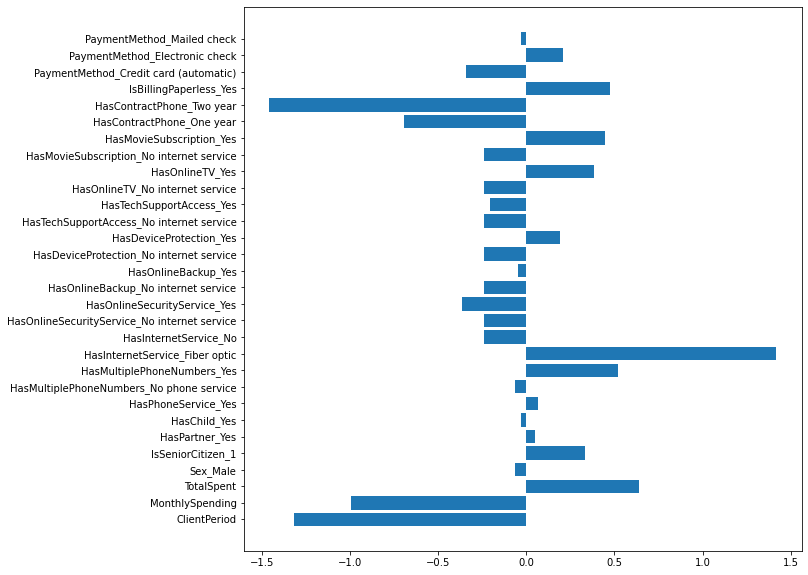

In [43]:
f_i = lrcv.coef_[0]
plt.figure(figsize=(10,10))
plt.barh(X_train.columns, f_i)
plt.show()

#### № 2 LogisticRegressionCV L1

- Попробуем тоже, но с L1 регуляризацией

In [44]:
lrcv_l1 = LogisticRegressionCV(cv = 5, scoring='roc_auc', penalty = "l1", solver = "liblinear")
lrcv_l1.fit(X_train, y_train)

LogisticRegressionCV(cv=5, penalty='l1', scoring='roc_auc', solver='liblinear')

In [45]:
y_train_predicted = lrcv_l1.predict_proba(X_train)[:, 1]
y_valid_predicted = lrcv_l1.predict_proba(X_valid)[:, 1]

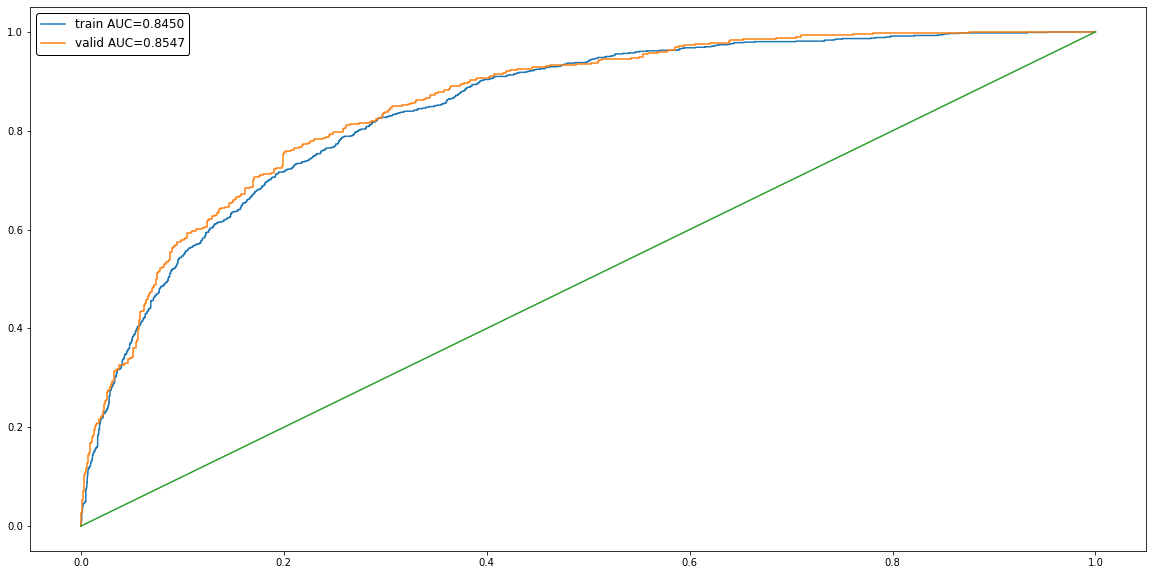

In [46]:
train_auc = roc_auc_score(y_train, y_train_predicted)
valid_auc = roc_auc_score(y_valid, y_valid_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_valid, y_valid_predicted)[:2], label='valid AUC={:.4f}'.format(valid_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

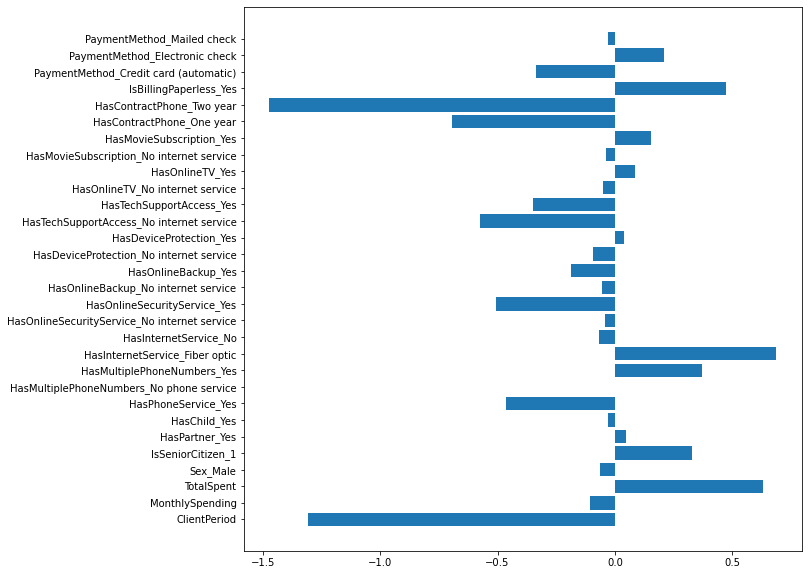

In [47]:
f_i = lrcv_l1.coef_[0]
plt.figure(figsize=(10,10))
plt.barh(X_train.columns, f_i)
plt.show()

- Можно попробовать взять только самые сильные признаки

In [48]:
strong = ['ClientPeriod', 'TotalSpent', 'HasPhoneService_Yes', 'IsSeniorCitizen_1', 
         'IsBillingPaperless_Yes', 'HasMultiplePhoneNumbers_Yes', 'HasInternetService_Fiber optic',  'HasOnlineSecurityService_Yes', 'HasOnlineBackup_No internet service',
         'HasContractPhone_One year',
       'HasContractPhone_Two year','IsBillingPaperless_Yes']

In [49]:
lrcv_l1.fit(X_train[strong], y_train)

LogisticRegressionCV(cv=5, penalty='l1', scoring='roc_auc', solver='liblinear')

In [50]:
y_train_predicted = lrcv_l1.predict_proba(X_train[strong])[:, 1]
y_valid_predicted = lrcv_l1.predict_proba(X_valid[strong])[:, 1]

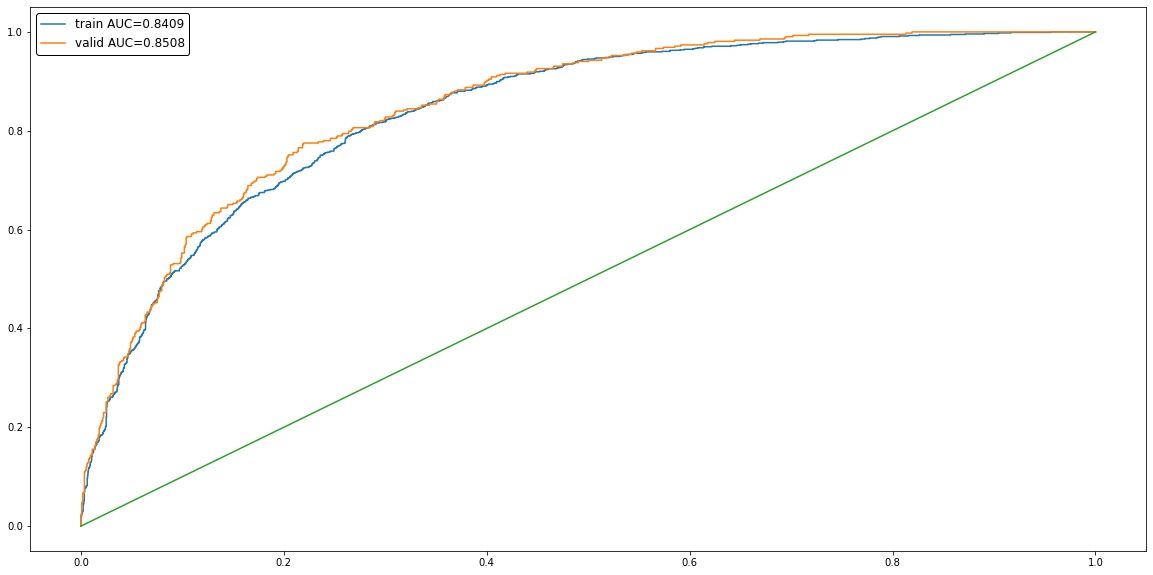

In [51]:
train_auc = roc_auc_score(y_train, y_train_predicted)
valid_auc = roc_auc_score(y_valid, y_valid_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_valid, y_valid_predicted)[:2], label='valid AUC={:.4f}'.format(valid_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

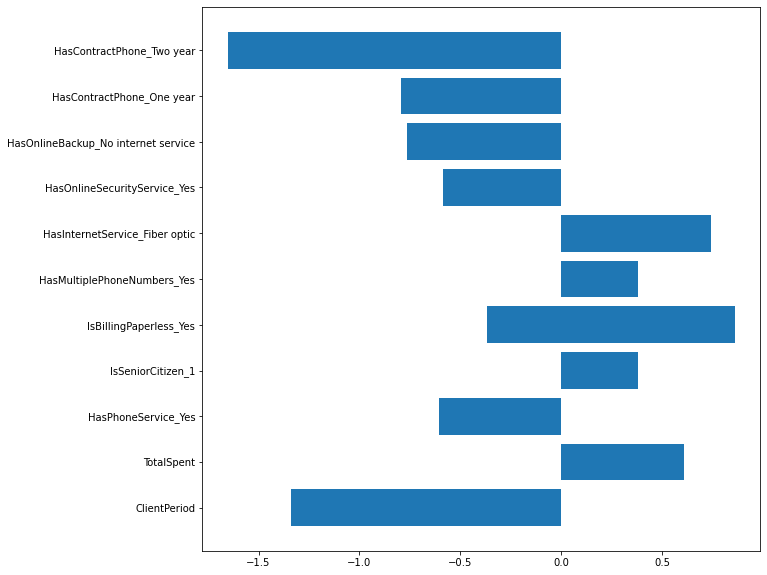

In [52]:
f_i = lrcv_l1.coef_[0]
plt.figure(figsize=(10,10))
plt.barh(X_train[strong].columns, f_i)
plt.show()

- Не особо помогло =)

#### № 3 KNN

In [53]:
from sklearn.neighbors import KNeighborsClassifier

In [54]:
model = KNeighborsClassifier()

parameters = {
    'n_neighbors': np.arange(25, 35),
}
gs = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    scoring='roc_auc',
    cv=5,
)

In [55]:
gs.fit(X_train, y_train);

In [56]:
gs.best_params_

{'n_neighbors': 34}

In [57]:
y_train_predicted = gs.predict_proba(X_train)[:, 1]
y_valid_predicted = gs.predict_proba(X_valid)[:, 1]

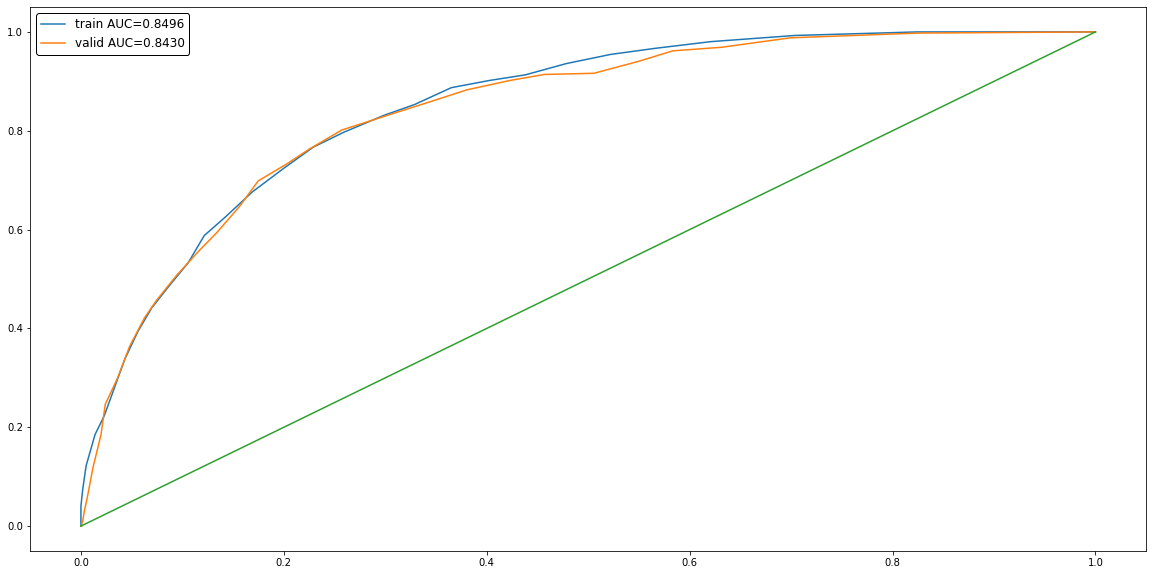

In [58]:
train_auc = roc_auc_score(y_train, y_train_predicted)
valid_auc = roc_auc_score(y_valid, y_valid_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_valid, y_valid_predicted)[:2], label='valid AUC={:.4f}'.format(valid_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

#### № 4 SVC

In [59]:
from sklearn.svm import SVC

In [60]:
model = SVC(probability=True)

parameters = {
    'C': [0.01, 0.1],
}
gs = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    scoring='roc_auc',
    cv=5,
)

In [61]:
gs.fit(X_train, y_train);

In [62]:
gs.best_params_

{'C': 0.01}

In [63]:
y_train_predicted = gs.predict_proba(X_train)[:, 1]
y_valid_predicted = gs.predict_proba(X_valid)[:, 1]

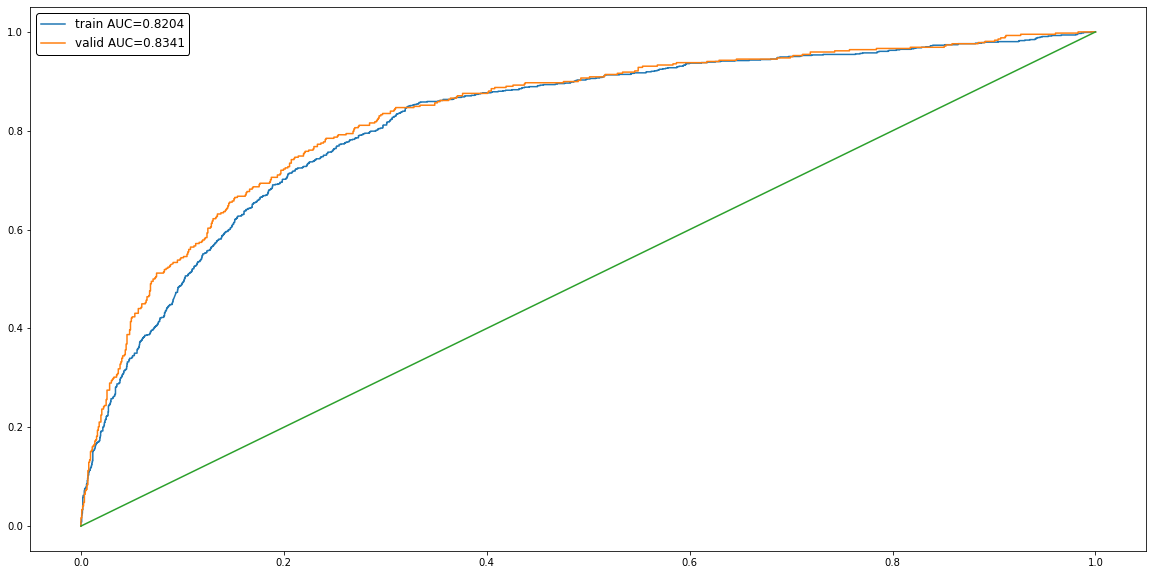

In [64]:
train_auc = roc_auc_score(y_train, y_train_predicted)
valid_auc = roc_auc_score(y_valid, y_valid_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_valid, y_valid_predicted)[:2], label='valid AUC={:.4f}'.format(valid_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

- Точность оказалась по ниже, при том, что и скорость обучения такого алгоритма маловата. Попробуем использовать только сильные признаки.

In [65]:
model = SVC(probability=True)

parameters = {
    'C': [0.01, 0.1],
}
gs = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    scoring='roc_auc',
    cv=5,
)

In [66]:
gs.fit(X_train[strong], y_train);
gs.best_params_

{'C': 0.01}

In [67]:
y_train_predicted = gs.predict_proba(X_train[strong])[:, 1]
y_valid_predicted = gs.predict_proba(X_valid[strong])[:, 1]

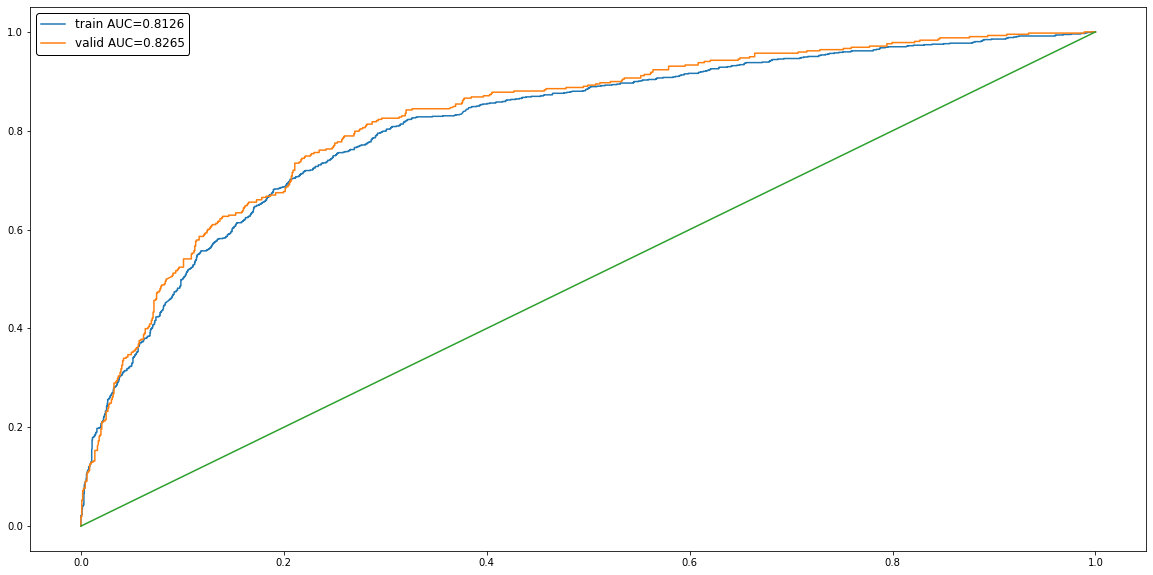

In [68]:
train_auc = roc_auc_score(y_train, y_train_predicted)
valid_auc = roc_auc_score(y_valid, y_valid_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_valid, y_valid_predicted)[:2], label='valid AUC={:.4f}'.format(valid_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

- Чтож, из линейных моделей самой бодрой получилась логистическая регрессия с L1 регуляризацией.
- Параметры: LogisticRegressionCV(cv=5, penalty='l1', scoring='roc_auc', solver='liblinear')
- Качество auc_score на валидационной выборке: 0.8546

## Применение градиентного бустинга 

In [69]:
from sklearn.ensemble import RandomForestClassifier
import xgboost
import catboost

#### №1 Простой лес

In [70]:
model = RandomForestClassifier()

parameters = {
    'n_estimators': [100,200,400],
    'max_depth': [4,5],
    'max_features': ['sqrt', 'log2'],
    
}
gs = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    scoring='roc_auc',
    cv=5,
)

In [71]:
gs.fit(X_train, y_train);
gs.best_params_

{'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200}

In [72]:
y_train_predicted = gs.predict_proba(X_train)[:, 1]
y_valid_predicted = gs.predict_proba(X_valid)[:, 1]

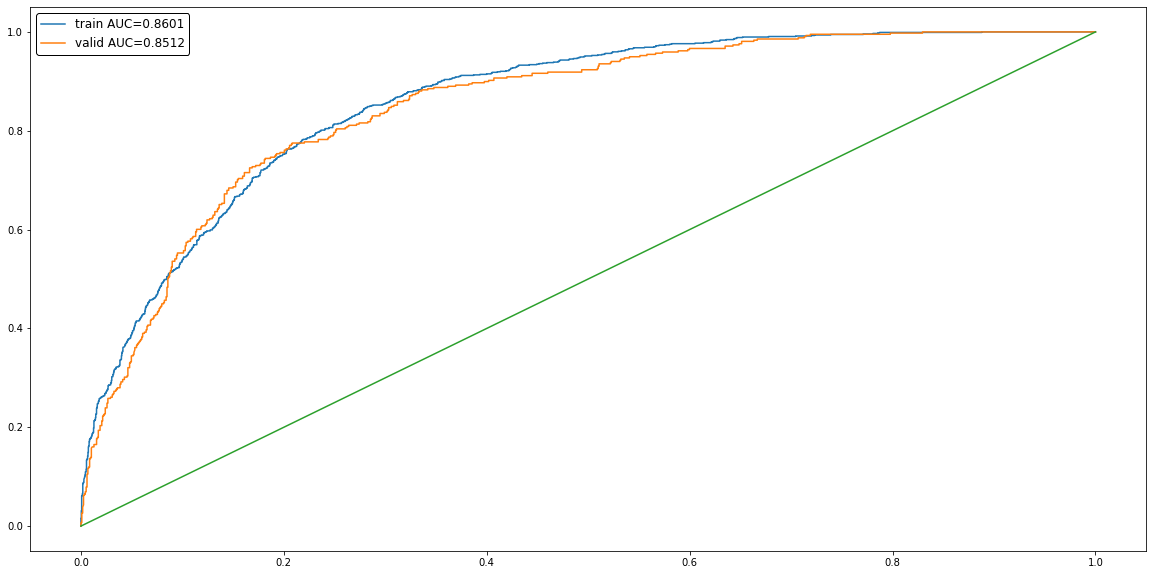

In [73]:
train_auc = roc_auc_score(y_train, y_train_predicted)
valid_auc = roc_auc_score(y_valid, y_valid_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_valid, y_valid_predicted)[:2], label='valid AUC={:.4f}'.format(valid_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

#### №2 Xgboost

In [74]:
model = xgboost.XGBClassifier(verbosity=0, gamma = 0.2, learning_rate = 0.09)

parameters = {
    'n_estimators': [70,150,100,200],
    'max_depth': [3,4,5], 

}
gs = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    scoring='roc_auc',
    cv=5,
)

In [75]:
gs.fit(X_train, y_train);
gs.best_params_

{'max_depth': 3, 'n_estimators': 70}

In [76]:
y_train_predicted = gs.predict_proba(X_train)[:, 1]
y_valid_predicted = gs.predict_proba(X_valid)[:, 1]

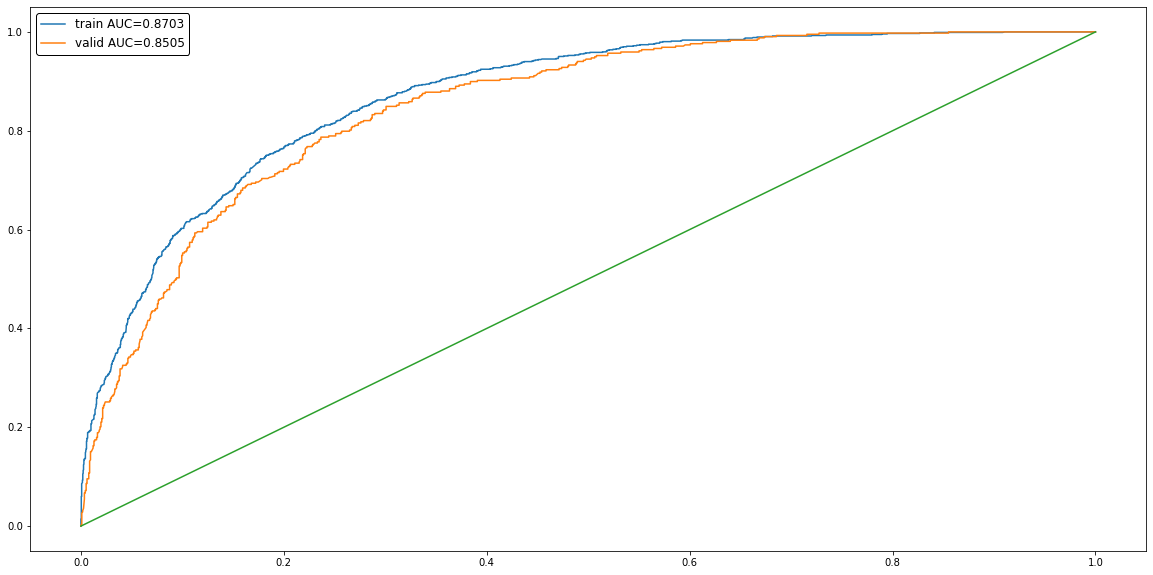

In [77]:
train_auc = roc_auc_score(y_train, y_train_predicted)
valid_auc = roc_auc_score(y_valid, y_valid_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_valid, y_valid_predicted)[:2], label='valid AUC={:.4f}'.format(valid_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

#### №3 catboost

In [97]:
X_train_cb, X_valid_cb, y_train, y_valid = train_test_split(data.drop("Churn", axis = 1), data['Churn'], test_size=0.3, random_state=47)

In [107]:
boosting_model = catboost.CatBoostClassifier(verbose=0, 
                                             cat_features=cat_cols,
                                             min_data_in_leaf = 5,
                                             eval_metric='AUC',
                                             iterations= 1200,
                                             learning_rate = 0.02,
                                             l2_leaf_reg = 3,
                                             depth= 6,
                                             class_weights = [1.0, 2.8]
                                             
                                            )

In [108]:
boosting_model.fit(X_train_cb, y_train)

In [109]:
y_train_predicted = boosting_model.predict_proba(X_train_cb)[:, 1]
y_valid_predicted = boosting_model.predict_proba(X_valid_cb)[:, 1]

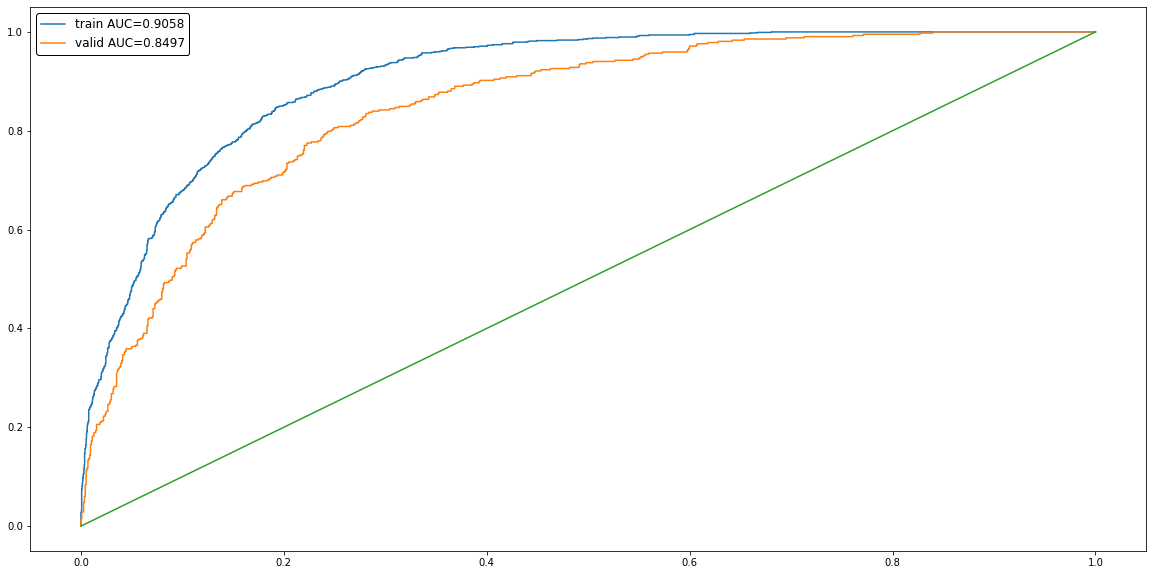

In [110]:
train_auc = roc_auc_score(y_train, y_train_predicted)
valid_auc = roc_auc_score(y_valid, y_valid_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_valid, y_valid_predicted)[:2], label='valid AUC={:.4f}'.format(valid_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

- Из деревьев получилось, что катбуст лучше всех справился. 
- Параметры модели min_data_in_leaf = 5, eval_metric='AUC', iterations= 600,learning_rate = 0.02, l2_leaf_reg = 0.5, depth= 3
- Точность на валидационной выборке 0.8555


## Предсказания

Заново загрузим и обработает данные.

In [83]:
data = pd.read_csv('./train.csv')
TotalSpent_median = 0

In [84]:
def prepare_data_train(df):
    df.loc[df['TotalSpent'] == ' ', 'TotalSpent'] = np.nan
    df['TotalSpent'] = df['TotalSpent'].astype(float) # Поменяем тип
    TotalSpent_median = df['TotalSpent'].median()
    df.loc[df['TotalSpent'].isnull(), 'TotalSpent'] = TotalSpent_median
    df['IsSeniorCitizen'] = df['IsSeniorCitizen'].astype(object) # Сделаем категориальную переменную, категориальной.
    X = df[feature_cols]
    return X

In [85]:
def prepare_data_test(df):
    df.loc[df['TotalSpent'] == ' ', 'TotalSpent'] = np.nan
    df['TotalSpent'] = df['TotalSpent'].astype(float) # Поменяем тип
    df.loc[df['TotalSpent'].isnull(), 'TotalSpent'] = TotalSpent_median
    df['IsSeniorCitizen'] = df['IsSeniorCitizen'].astype(object) # Сделаем категориальную переменную, категориальной.
    
    return df

In [86]:
X_train = prepare_data_train(data)
y_train = data['Churn']

Обучим лидера.

In [87]:
best_model = catboost.CatBoostClassifier(verbose=0, 
                                             cat_features=cat_cols,
                                             min_data_in_leaf = 5,
                                             eval_metric='AUC',
                                             iterations= 600,
                                             learning_rate = 0.02,
                                             l2_leaf_reg = 0.5,
                                             depth= 3
                                             
                                             
                                            )
best_model.fit(X_train, y_train)

In [88]:
X_test = pd.read_csv('./test.csv')

In [89]:
X_test = prepare_data_test(X_test)

In [90]:
submission = pd.read_csv('./submission.csv')

In [91]:
submission['Churn'] = best_model.predict_proba(X_test)[:, 1]

In [92]:
submission.to_csv('./my_submission3.csv', index = False)

- В целом все модели сработали примерно одинаково. К примеру ЛогРегрессия с L1 показывает практически такиеже результаты как catboost. Но на мой взгляд тут дело в малом количестве данных, для бустинга такое количество слишком мало, что бы расскрыть свой потенциал.

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.